In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
import warnings
import re

warnings.filterwarnings('ignore')


# Load Data

In [7]:
df = pd.read_csv('IS4242 Data.csv')
df.head()

,speech,label,label2,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,...,chroma_1,chroma_8,spectral_1,spectral_2,tonnetz_1,tonnetz_2,tonnetz_3,tonnetz_4,tonnetz_5,tonnetz_6
0,../data\Angry_Female\anger_xn_1.wav,angry,angry_female,-494.27545,134.56302,-25.692625,44.874004,-6.713496,-20.871096,13.515034,...,0.402734,0.503801,31.923484,17.956310,0.059400,0.014392,0.118363,0.036899,0.047293,-0.028096
1,../data\Angry_Female\anger_xn_10.wav,angry,angry_female,-489.23740,95.24146,-6.124708,45.021780,-1.017477,-12.822159,15.770240,...,0.409627,0.526004,29.469380,16.135760,-0.010318,0.051561,0.045706,-0.027530,-0.004011,-0.008055
2,../data\Angry_Female\anger_xn_11.wav,angry,angry_female,-520.55280,101.38983,-10.185467,41.562035,3.115262,-10.974776,11.411966,...,0.627573,0.540234,28.944638,13.118379,0.005677,-0.002739,0.116942,0.065897,-0.005532,-0.037391
3,../data\Angry_Female\anger_xn_12.wav,angry,angry_female,-490.04434,127.46854,-25.104696,38.669410,-12.717003,-19.364574,20.204561,...,0.454550,0.499391,29.633752,15.092322,0.042003,0.046887,0.056951,0.035294,0.028878,-0.020695
4,../data\Angry_Female\anger_xn_13.wav,angry,angry_female,-475.49997,120.51346,-31.929777,47.917557,-6.103209,-19.414783,9.694456,...,0.350280,0.550284,30.638892,15.346131,0.019974,0.033962,0.098241,0.080186,0.020042,-0.017513


In [8]:
import re

# Regular expression pattern to match text between backslashes
pattern = r'\\(.*?)\\'
df['label2'] = df['speech'].apply(lambda x: re.findall(pattern, x)[0].lower())
df.head()

,speech,label,label2,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,...,chroma_1,chroma_8,spectral_1,spectral_2,tonnetz_1,tonnetz_2,tonnetz_3,tonnetz_4,tonnetz_5,tonnetz_6
0,../data\Angry_Female\anger_xn_1.wav,angry,angry_female,-494.27545,134.56302,-25.692625,44.874004,-6.713496,-20.871096,13.515034,...,0.402734,0.503801,31.923484,17.956310,0.059400,0.014392,0.118363,0.036899,0.047293,-0.028096
1,../data\Angry_Female\anger_xn_10.wav,angry,angry_female,-489.23740,95.24146,-6.124708,45.021780,-1.017477,-12.822159,15.770240,...,0.409627,0.526004,29.469380,16.135760,-0.010318,0.051561,0.045706,-0.027530,-0.004011,-0.008055
2,../data\Angry_Female\anger_xn_11.wav,angry,angry_female,-520.55280,101.38983,-10.185467,41.562035,3.115262,-10.974776,11.411966,...,0.627573,0.540234,28.944638,13.118379,0.005677,-0.002739,0.116942,0.065897,-0.005532,-0.037391
3,../data\Angry_Female\anger_xn_12.wav,angry,angry_female,-490.04434,127.46854,-25.104696,38.669410,-12.717003,-19.364574,20.204561,...,0.454550,0.499391,29.633752,15.092322,0.042003,0.046887,0.056951,0.035294,0.028878,-0.020695
4,../data\Angry_Female\anger_xn_13.wav,angry,angry_female,-475.49997,120.51346,-31.929777,47.917557,-6.103209,-19.414783,9.694456,...,0.350280,0.550284,30.638892,15.346131,0.019974,0.033962,0.098241,0.080186,0.020042,-0.017513


# EDA

<Axes: xlabel='label'>

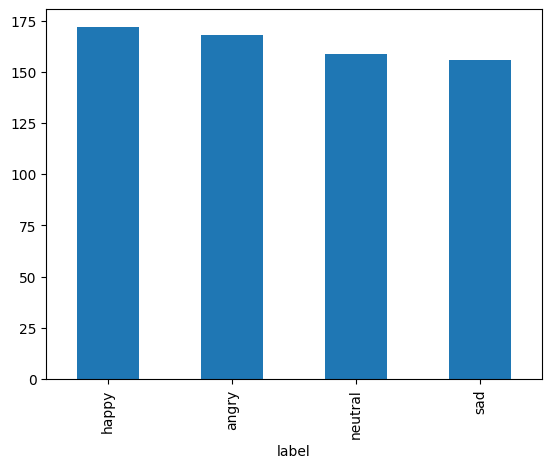

In [9]:
df['label'].value_counts().plot(kind='bar')

# Model Training

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc, f1_score, confusion_matrix, classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

from sklearn.preprocessing import label_binarize
from itertools import cycle
from sklearn.model_selection import GridSearchCV

In [10]:
X = df.drop(['speech', 'label', 'label2'], axis=1)
y = df['label2']

In [11]:
# Data Splitting
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

In [12]:
# Evaluation Method
def evaluate_model(model, model_name, x_test, y_test):
    # Binarize the output
    classes = np.unique(y_test)
    y_test_binarized = label_binarize(y_test, classes=classes)

    # Predict probabilities for each class
    y_probs = model.predict_proba(x_test)

    # Compute ROC curve and ROC area for each class
    n_classes = y_test_binarized.shape[1]
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_probs.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Plot ROC curve for a specific class
    plt.figure(figsize=(10, 8))
    colors = cycle(['red', 'orange', 'yellow', 'green', 'blue', 'purple', 'pink', 'brown'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'.format(classes[i], roc_auc[i]))
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic for {model_name}')
    plt.legend(loc="lower right")
    plt.show()

    # Additional evaluation metrics
    y_pred = model.predict(x_test)
    print(f'Accuracy Score for {model_name}: {model.score(x_test, y_test)}')
    print(f'Precision Score (weighted) for {model_name}: {precision_score(y_test, y_pred, average="weighted")}')
    print(f'Recall Score (weighted) for {model_name}: {recall_score(y_test, y_pred, average="weighted")}')
    print(f'F1 Score (weighted) for {model_name}: {f1_score(y_test, y_pred, average="weighted")}')
    print()
    print(f'Classification Report for {model_name}:\n{classification_report(y_test, y_pred)}')
    print(f'Confusion Matrix for {model_name}:\n{confusion_matrix(y_test, y_pred)}')


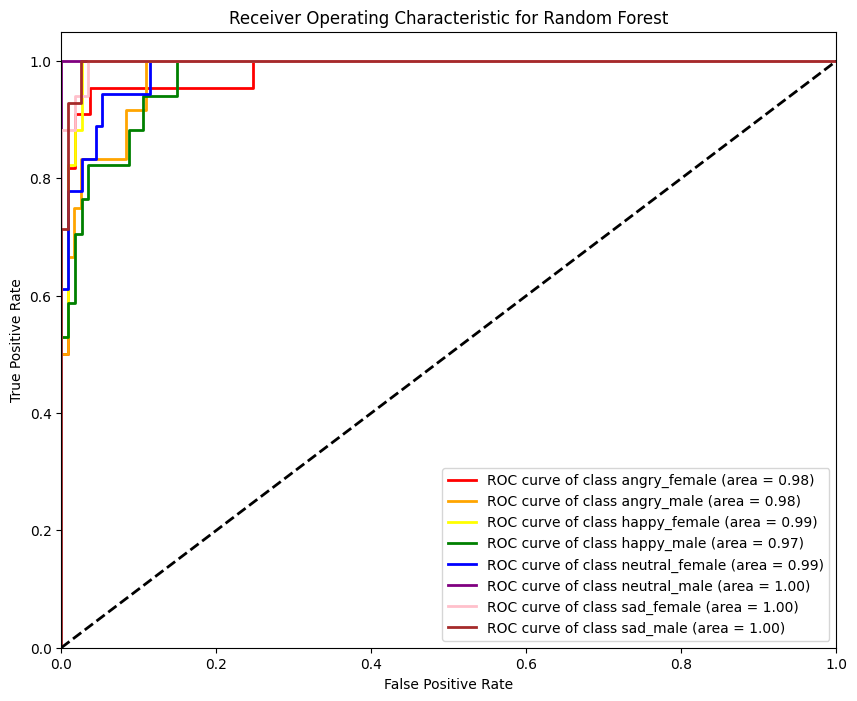

Accuracy Score for Random Forest: 0.8931297709923665
Precision Score (weighted) for Random Forest: 0.9042408821034775
Recall Score (weighted) for Random Forest: 0.8931297709923665
F1 Score (weighted) for Random Forest: 0.8918532674006961

Classification Report for Random Forest:
                precision    recall  f1-score   support

  angry_female       0.83      0.91      0.87        22
    angry_male       1.00      0.67      0.80        12
  happy_female       0.93      0.82      0.87        17
    happy_male       0.94      0.94      0.94        17
neutral_female       0.85      0.94      0.89        18
  neutral_male       0.93      1.00      0.97        14
    sad_female       1.00      0.82      0.90        17
      sad_male       0.78      1.00      0.88        14

      accuracy                           0.89       131
     macro avg       0.91      0.89      0.89       131
  weighted avg       0.90      0.89      0.89       131

Confusion Matrix for Random Forest:
[[20  0  

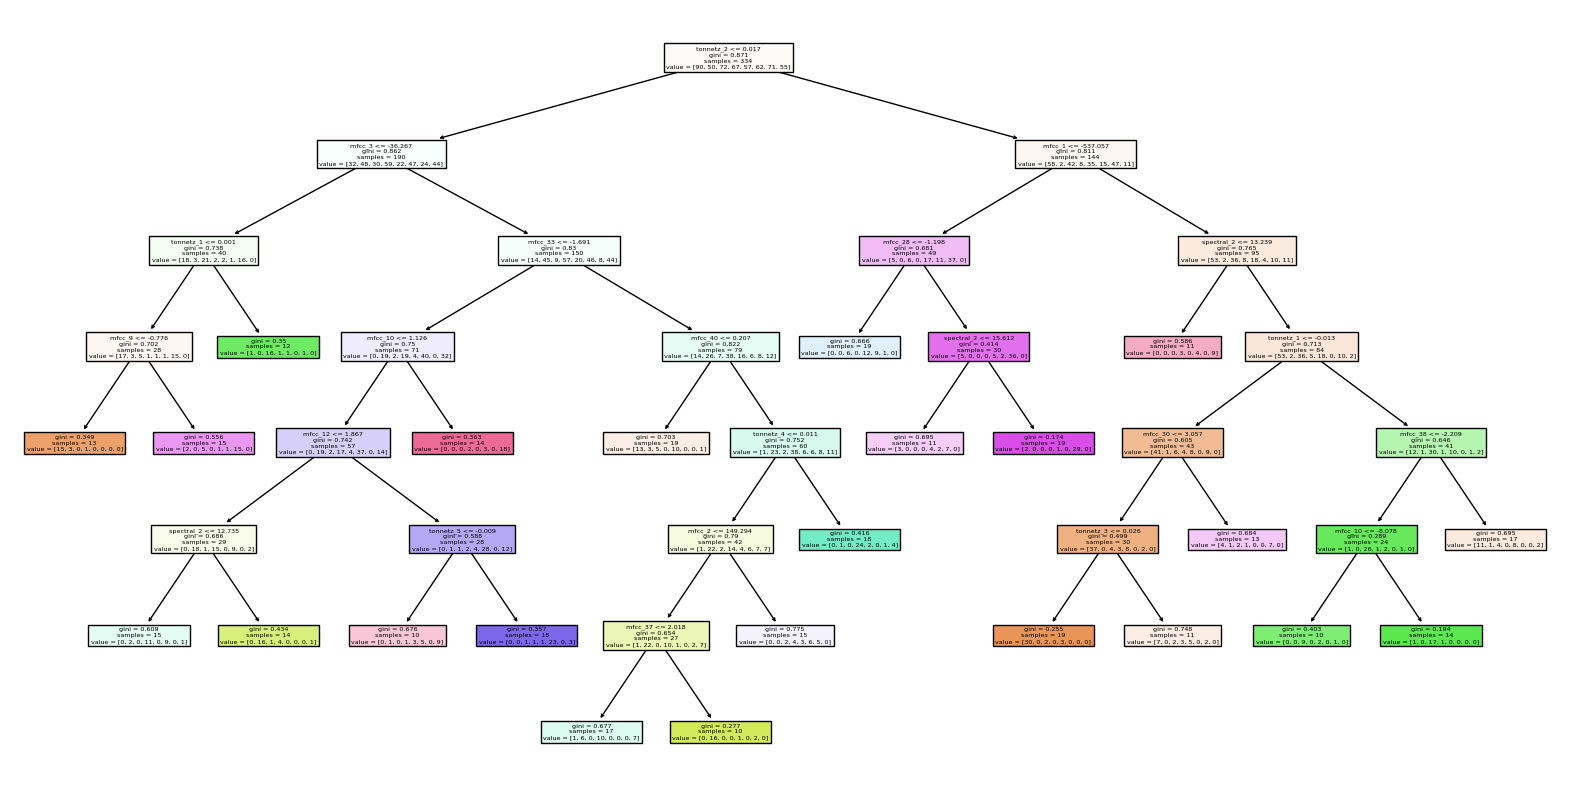

Number of trees in the forest: 200
Maximum depth of trees: 10


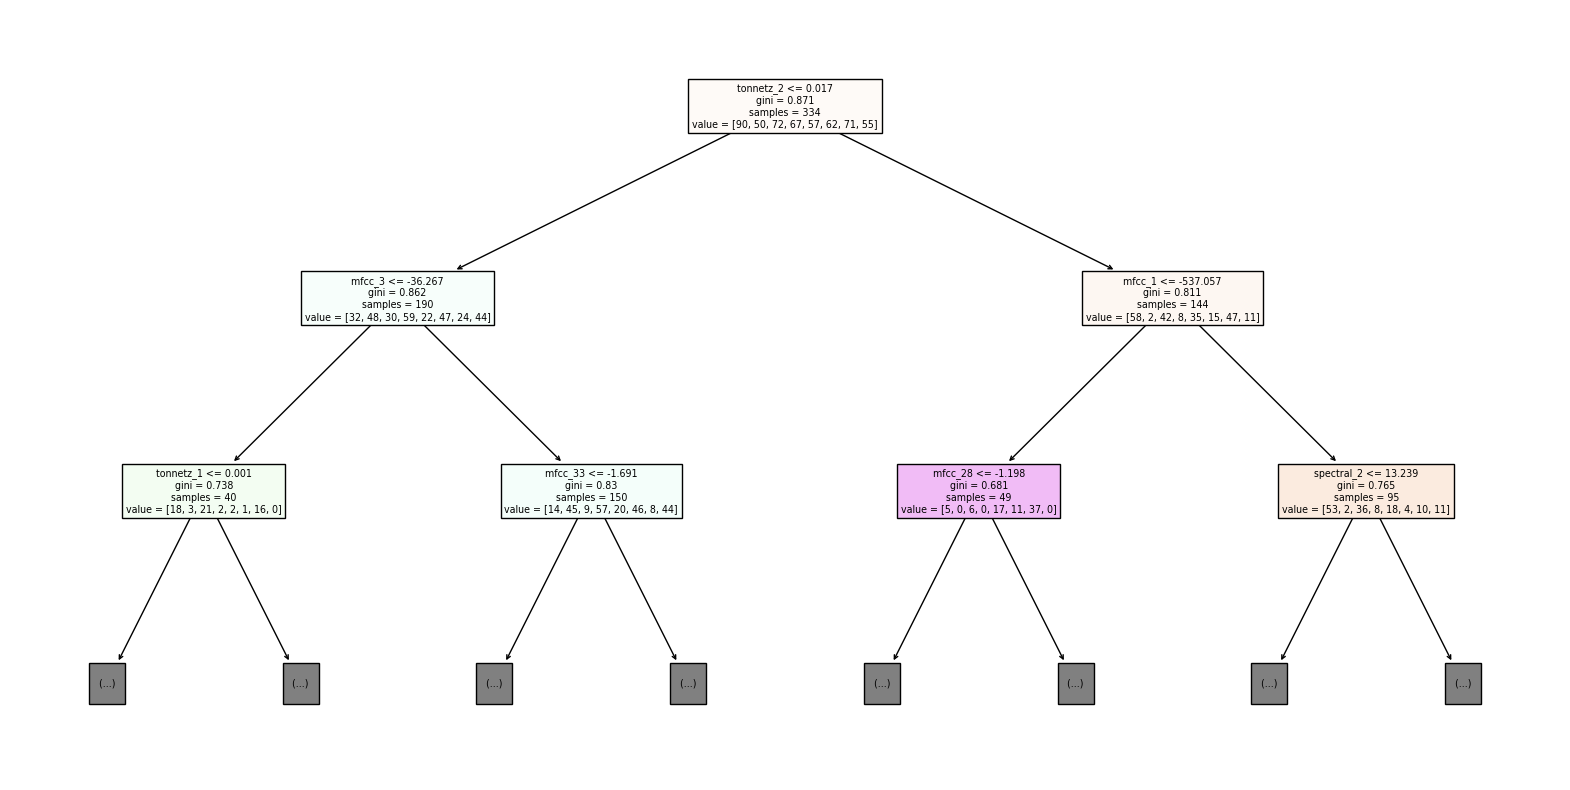

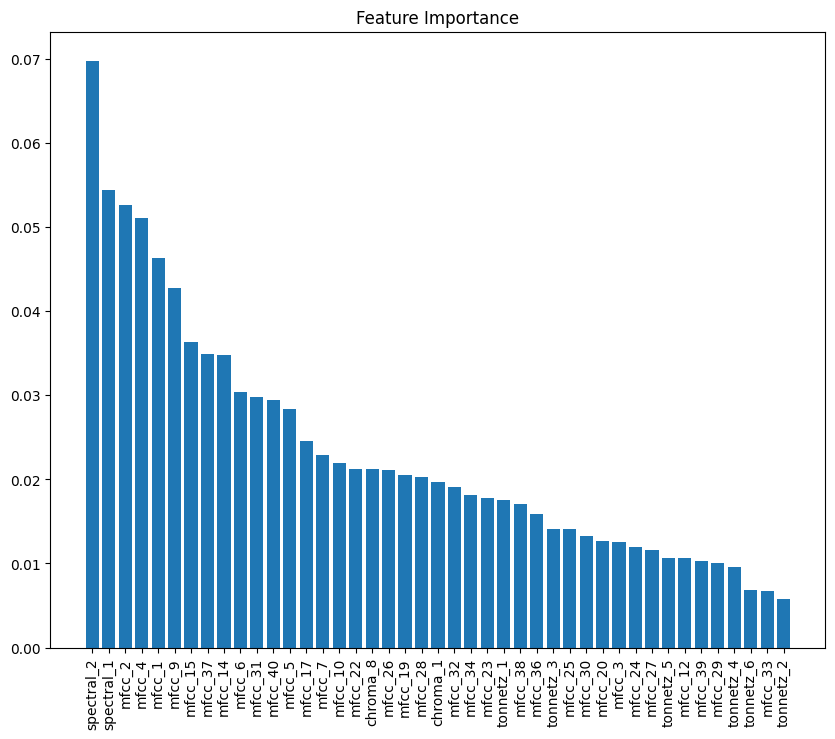

In [15]:
# Initialize the Random Forest model with a random state
# random_forest_model = RandomForestClassifier(random_state=42)

random_forest_model = RandomForestClassifier(
    n_estimators=200,    # Use more trees
    max_depth=10,         # Limit the depth of trees
    min_samples_split=20, # Minimum number of samples required to split an internal node
    min_samples_leaf=10,   # Minimum number of samples required to be at a leaf node
    max_features='sqrt',  # Number of features to consider at each split
    bootstrap=True,        # Use bootstrapping
    random_state=42
)


random_forest_model.fit(X_train, y_train)
evaluate_model(random_forest_model, "Random Forest", X_test, y_test)

# print out the tree diagram
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(random_forest_model.estimators_[0], feature_names=X.columns, filled=True)
plt.show()

# count the number of trees in the forest
n_trees = len(random_forest_model.estimators_)
print(f'Number of trees in the forest: {n_trees}')

# print the deepth of each tree
depths = [estimator.tree_.max_depth for estimator in random_forest_model.estimators_]
print(f'Maximum depth of trees: {np.max(depths)}')

# # print first 5 trees
# for i in range(5):
#     plt.figure(figsize=(20, 10))
#     plot_tree(random_forest_model.estimators_[i], feature_names=X.columns, filled=True)
#     plt.show()

# print first two levels of the first tree
plt.figure(figsize=(20, 10))
plot_tree(random_forest_model.estimators_[0], feature_names=X.columns, filled=True, max_depth=2)
plt.show()


# Feature Importance
importances = random_forest_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 8))
plt.title("Feature Importance")
plt.bar(range(X_train.shape[1]), importances[indices])
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.show()


